In [312]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [325]:
def gen1(chain_element):
#creates new location in parameter space by taking step from current one (in chain_element)
#based on increment from the generate function
    scale=1.0
    cov=np.array([[1.,0.],[0.,1.]])
    step=generate(cov,scale)
    chain_new=copy.deepcopy(chain_element)
 #   print 'chain_element is',type(chain_element)
 #   print 'chain_new is', type(chain_new)
    chain_new['length']+=step[0]
    chain_new['width']+=step[1]
    return chain_new

def generate(cov,scale=1.0):
#This function returns an array of Gaussian random numbers from
#a normal distribution with zero mean and covariance, scale^2*cov
    w,v = np.linalg.eig(cov)
    x=np.sqrt(w)*np.random.normal(0.0,1.0,w.size)
    res=np.zeros((w.size),float)
    for i in range(0,w.size):
        for alpha in range(0,w.size):
            res[alpha]=res[alpha]+v[alpha,i]*x[i]
    return scale*res

In [175]:
##Test gen1
chain_element=gen1(chain_init)
chain_element


{'area': array([ 76.65]),
 'length': array([ 6.09539288]),
 'lnlike': array([ 0.]),
 'width': array([ 12.8512126])}

In [165]:
def generate_test(nsamp,cov):
#draw nsamp samples from generate with covariance matrix cov and default scale
    mat=np.zeros(cov.shape[1],float)
    for i in range(0,nsamp):
        samp=generate(cov)
        mat=mat+np.outer(samp,samp)
    return mat/nsamp
        

In [43]:
cov


array([[ 2.,  1.],
       [ 1.,  2.]])

In [120]:
res=generate_test(10000,cov)

In [121]:
print res


[[ 2.06856383  1.02510738]
 [ 1.02510738  2.00978906]]


In [254]:
def lnlike1(d,chain_element):
    m=np.array([chain_element['length'][0],chain_element['width'][0]])
    cov = np.array([[1.0,0.0],[0.,1.]])
    return gausslike(d,m,cov)
    

def gausslike(d,m,cov):
#simple Gaussian likelihood where 
#d = data array (e.g., measurement of length and a measurement of width),
#m = model parameters (.e.g, true length and true width), and
#cov = error covariance mtrix
    weight=np.linalg.inv(cov)
    lnlike=-np.inner(d-m,np.inner(weight,d-m))
    return lnlike

In [371]:
#create 2D likelihood grid
d=np.array([7.,10.])
length=np.arange(4.,10.,0.1)
width=np.arange(7.,13.,0.1)
lnlike=np.zeros((width.size,length.size),float)
chain_in={'length':np.zeros(1),'width':np.zeros(1)}
for i in range(0,length.size-1):
    chain_in['length']=np.array([length[i]])
    for j in range(0,width.size-1):
        chain_in['width']=np.array([width[j]])
        lnlike[j,i]=lnlike1(d,chain_in)


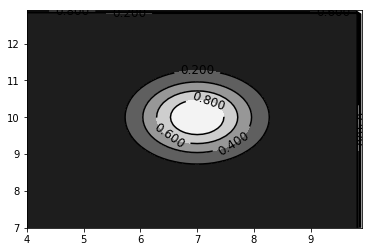

In [375]:
#plot the 2D likelihood grid as shaded contour plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Reversed Greys colourmap for filled contours
cpf = ax.contourf(length,width,np.exp(lnlike), 4, cmap=cm.Greys_r)
# Set the colours of the contours and labels so they're white where the
# contour fill is dark (Z < 0) and black where it's light (Z >= 0)
colours = ['w' if level<0 else 'k' for level in cpf.levels]
cp = ax.contour(length, width, np.exp(lnlike), 4, colors=colours)
ax.clabel(cp, fontsize=12, colors=colours)
plt.show()

In [286]:
chain_init={'length':np.array([10.5]), 'width':np.array([7.3]),'lnlike':np.array([0.])}
chain_init['area']=chain_init['length']*chain_init['width']
chain=chain_init
list(chain)

['width', 'length', 'area', 'lnlike']

In [65]:
chain['area']

array([ 76.65])

In [125]:
chain


{'area': array([ 76.65]),
 'length': array([ 10.5]),
 'lnlike': array([ 0.]),
 'width': array([ 7.3])}

In [255]:
d=np.array([10.0,7.0])

In [326]:
def chain_update(d,like,gen,chain):
#increments the chain by 1 element by taking a step (or not) using metropolis hastings algorithm
#d = data array
#like = name of the log likelihood function (e.g. lnlike1)
#gen: trial step generating function
#chain: dictionary holding arrays of parameter values, likelihood, and derived parameter values
    reject=0 #increments to 1 if rejected
    nchainelements=chain[list(chain)[0]].size  #number of parameter space locations in chain
    chainlast={}                            #new chain that will hold just hte last location in parameter space
    for string in list(chain):
#        print string, chain[string].size
        chainlast[string]=np.array([chain[string][-1]])
    lnlike_current=like(d,chainlast)
#    print 'linlike_current is', lnlike_current
    location_proposed=gen(chainlast)
    lnlike_proposed=like(d,location_proposed)
#    print 'linlike_proposed is', lnlike_proposed

    if lnlike_proposed >= lnlike_current:
        location_new = location_proposed
        location_new['lnlike']=np.array([lnlike_proposed])
 #       print 'accepted'
    else:
        alpha= np.exp(lnlike_proposed-lnlike_current)
#        print 'alpha is', alpha
        if np.random.uniform(0,1) < alpha :
            location_new = location_proposed
            location_new['lnlike']=np.array([lnlike_proposed])
 #           print 'accepted'
        else:
            location_new=chainlast
            location_new['lnlike']=np.array([lnlike_current])
            reject=1
 #           print 'rejected'
#    print location_new
#    print 'chainlast:', chainlast
    for string in list(chain):
        chain[string]=np.append(chain[string],location_new[string])
#    print 'new chain is', chain 
    return reject
    

In [251]:
chain[list(chain)[0]].size

2

In [289]:
chain

{'area': array([ 76.65,  76.65,  76.65]),
 'length': array([ 10.5       ,   9.08734307,   8.83297388]),
 'lnlike': array([ 0.        , -0.34      , -0.83914114]),
 'width': array([ 7.3       ,  7.07873034,  7.69404111])}

In [327]:
d=np.array([10.0,7.0]) #this is the dataset -- perhaps I should have just put this inside the likelihood function
chain_init={'length':np.array([10.5]), 'width':np.array([7.3]),'lnlike':np.array([0.])}
chain_init['area']=chain_init['length']*chain_init['width']
chain=chain_init
list(chain)

nsamp=10000
total_reject=0
for i in range(0,nsamp):
    reject = chain_update(d,lnlike1,gen1,chain)
    total_reject=total_reject+reject
#    print 'reject =',reject
accept_rate=1.-1.*total_reject/(1.*nsamp)
accept_rate

0.42290000000000005

In [107]:
import matplotlib.pyplot as plt

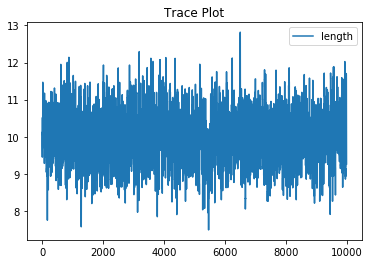

In [376]:
i = range(1,nsamp)

plt.plot(i, chain['length'][i], label='length')
plt.title("Trace Plot")
plt.legend()
plt.show()

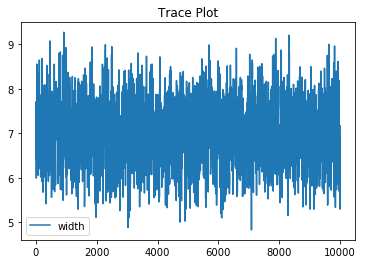

In [377]:
i = range(1,10000)

plt.plot(i, chain['width'][i], label='width')
plt.title("Trace Plot")
plt.legend()
plt.show()

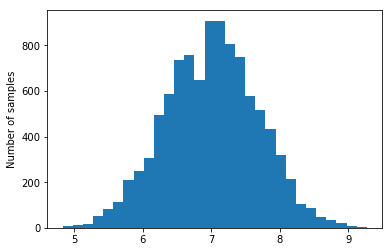

In [334]:
x=chain['width']
plt.hist(x, bins=30)
plt.ylabel('Number of samples')
plt.show()

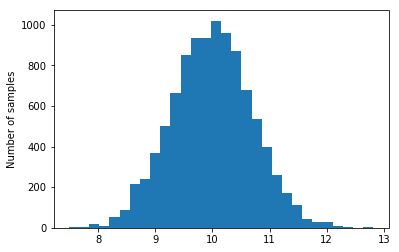

In [335]:
x=chain['length']
plt.hist(x, bins=30)
plt.ylabel('Number of samples')
plt.show()

In [366]:
d=np.array([7.0,10.0])
step=0.25
lmin=min(chain['length']) ; lmax=max(chain['length']) ; wmin=min(chain['width']) ; wmax=max(chain['width'])
length=np.arange(lmin,lmax,step)
width=np.arange(wmin,wmax,step)
counts=np.zeros((width.size,length.size),long)
for i in range(1,nsamp-1):
    l=int((chain['length'][i]-lmin)/step)
    w=int((chain['width'][i]-wmin)/step)
    counts[w,l]+=1    

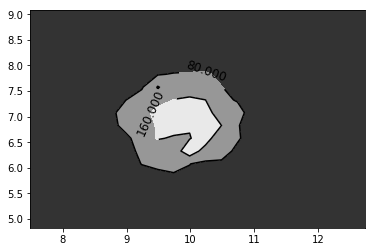

In [368]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111)

# Reversed Greys colourmap for filled contours
cpf = ax.contourf(length,width,counts, 2, cmap=cm.Greys_r)
# Set the colours of the contours and labels so they're white where the
# contour fill is dark (Z < 0) and black where it's light (Z >= 0)
colours = ['w' if level<0 else 'k' for level in cpf.levels]
cp = ax.contour( length,width,counts, 2, colors=colours)
ax.clabel(cp, fontsize=12, colors=colours)
plt.show()